## <font color = darkblue>  This program provides starter code for Logistic Regression, SVM and Decision Tree
The=is starter program uses a toy dataset called Titanic. The data has a binary response Survive: (survived or not), and the program shows various options of predicting it. 
You may ignore the Decision Tree part as it has not been discussed in the class yet.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
# ----------------------------
# Load the data
# ----------------------------
df = pd.read_csv('LoanStats_2018Q1_Cleaned_II.csv')
df.head()

,addr_state,all_util,annual_inc,avg_cur_bal,delinq_2yrs,disbursement_method,dti,emp_length,grade,home_ownership,...,title,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_rec_int
0,OR,54.0,51738.0,739.0,0,Cash,6.87,8 years,C,RENT,...,Debt consolidation,8126,15094,44,8126,4500,7,5394,997.50,333.77
1,CT,39.0,240000.0,16812.0,0,Cash,10.99,10+ years,A,MORTGAGE,...,Credit card refinancing,235372,480251,23,82258,117600,0,65651,1453.71,225.43
2,GA,16.0,85000.0,14244.0,1,Cash,9.12,10+ years,B,MORTGAGE,...,Other,327618,344165,33,59039,20900,1,28337,393.59,90.65
3,NY,75.0,42000.0,1817.0,0,Cash,6.94,1 year,A,RENT,...,Debt consolidation,14533,19350,8,14533,6100,0,13250,404.60,85.47
4,WA,52.0,100000.0,2851.0,0,Cash,24.95,10+ years,A,OWN,...,Debt consolidation,62727,120356,33,62727,32500,0,54556,1356.51,250.06


In [59]:
df.shape

(96829, 52)

## <font color = darkblue> Part 1: 

Perform individual feature outlier analysis and eliminate up to 1% of rows each based on the following  columns: dti, annual income, delinq_2yrs. This step will prepare us for the discussion on multidimensional outlier analysis next week. 

array([[<Axes: title={'center': 'delinq_2yrs'}>]], dtype=object)

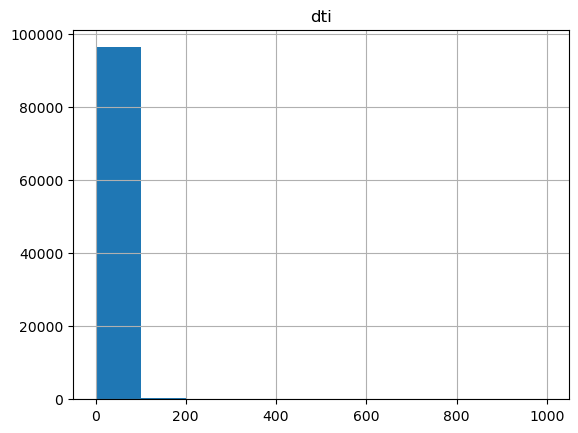

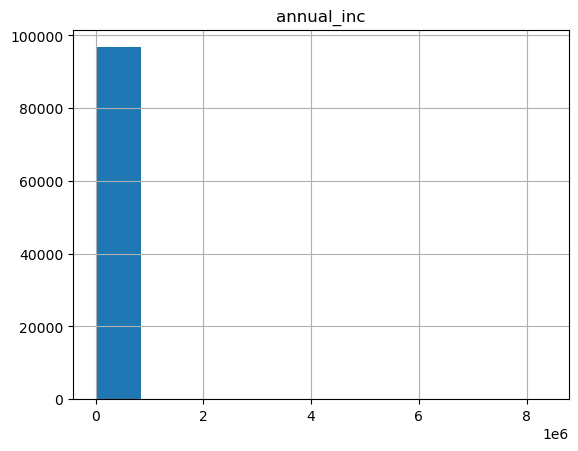

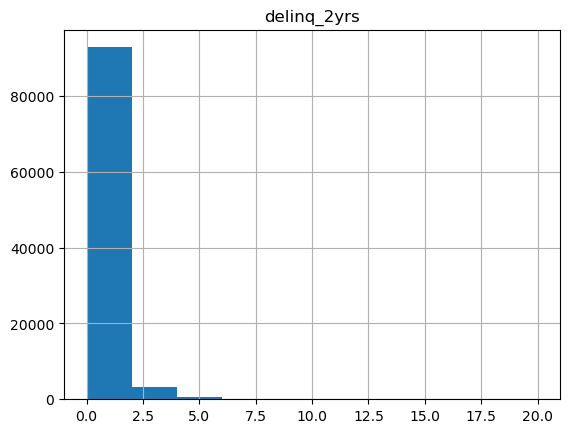

In [12]:
df.hist('dti')
df.hist('annual_inc')
df.hist('delinq_2yrs')

In [3]:
# Function to remove up to 1% of rows based on a given column
def remove_outliers(df, column):
    # Calculate the 0.5% and 99.5% percentiles
    lower_percentile = df[column].quantile(0.005)
    upper_percentile = df[column].quantile(0.995)
    
    # Keep only the rows within the bounds
    df_filtered = df[(df[column] >= lower_percentile) & (df[column] <= upper_percentile)]
    
    return df_filtered

# Columns for outlier analysis
columns_to_check = ['dti', 'annual_inc', 'delinq_2yrs']

# Removing up to 1% of rows for each column
for column in columns_to_check:
    df = remove_outliers(df, column)


array([[<Axes: title={'center': 'delinq_2yrs'}>]], dtype=object)

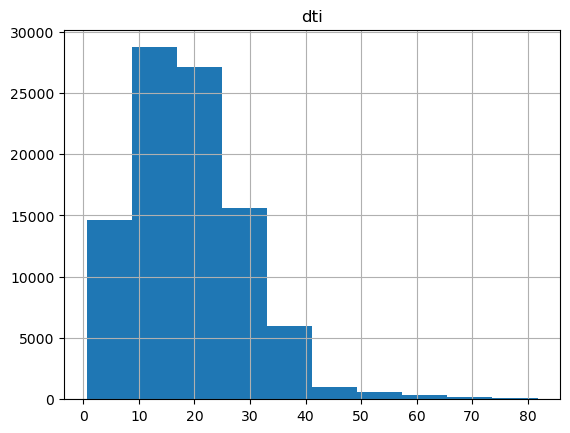

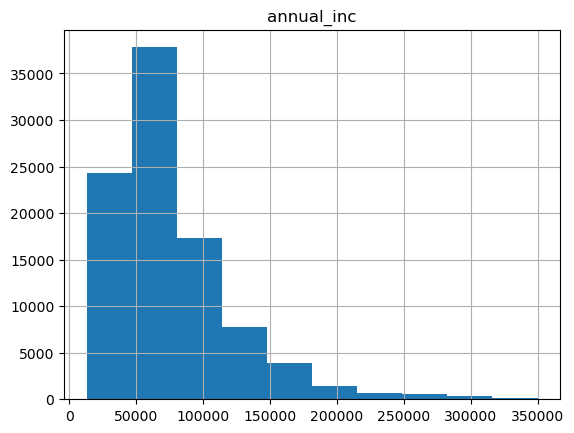

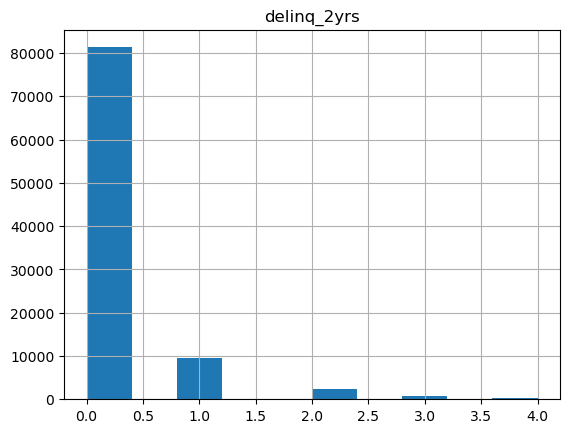

In [14]:
#recheck
df.hist('dti')
df.hist('annual_inc')
df.hist('delinq_2yrs')

## <font color = darkblue> Part 2:

a) Build a logistic model to accurately predict the two response variables listed above.

b) Discuss which variables are significant and how that may help Lending Club make predictions.

c) Build an SVM model to accurately predict the two responses.

## <font color = darkblue> Logistic Regression

In [73]:
# Print only the categorical columns 
listofcat = list(df.select_dtypes(include = ['object']))
listofcat

['addr_state',
 'disbursement_method',
 'emp_length',
 'grade',
 'home_ownership',
 'initial_list_status',
 'loan_amnt_cat',
 'loan_amnt_HighLow',
 'loan_amnt_HighMedium',
 'loan_status',
 'pub_rec',
 'sub_grade',
 'term',
 'title']

In [4]:
# convert the 'emp_length' variable into integer type

# extract the text 
df['emp_length'] = df['emp_length'].str.extract('(\d+)')

# Convert the extracted numeric part to integer
df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')

In [5]:
# Encoding categorical features
categorical_features = ['disbursement_method', 'home_ownership', 'pub_rec']

# Perform one-hot encoding on the categorical columns
encoded_features = pd.get_dummies(df[categorical_features])

# # Drop the original categorical columns from 'df'
df_dropped = df.drop(categorical_features, axis=1)

# # Concatenate the encoded features with the rest of the dataframe
transformed_df = pd.concat([df_dropped, encoded_features], axis=1)
transformed_df


,addr_state,all_util,annual_inc,avg_cur_bal,delinq_2yrs,dti,emp_length,grade,initial_list_status,inq_fi,...,total_rec_int,disbursement_method_Cash,disbursement_method_DirectPay,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,pub_rec_0,pub_rec_1,pub_rec_2 or more
0,OR,54.0,51738.0,739.0,0,6.87,8.0,C,w,0,...,333.77,1,0,0,0,0,1,0,1,0
1,CT,39.0,240000.0,16812.0,0,10.99,10.0,A,w,0,...,225.43,1,0,0,1,0,0,1,0,0
2,GA,16.0,85000.0,14244.0,1,9.12,10.0,B,w,0,...,90.65,1,0,0,1,0,0,1,0,0
3,NY,75.0,42000.0,1817.0,0,6.94,1.0,A,w,0,...,85.47,1,0,0,0,0,1,1,0,0
4,WA,52.0,100000.0,2851.0,0,24.95,10.0,A,w,1,...,250.06,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96824,UT,51.0,56000.0,2118.0,0,35.50,4.0,C,f,1,...,338.73,1,0,0,0,0,1,0,0,1
96825,NY,39.0,47000.0,1829.0,0,15.37,10.0,B,w,0,...,982.87,1,0,0,0,0,1,1,0,0
96826,NH,71.0,50000.0,20965.0,0,28.93,10.0,B,w,1,...,350.76,1,0,0,1,0,0,1,0,0
96827,IL,56.0,52000.0,9899.0,0,33.72,10.0,C,w,3,...,331.20,1,0,0,1,0,0,1,0,0


In [6]:
# -------------------------------------------------
## Removing the unused columns from the df
# -------------------------------------------------

cols_to_remove = ['addr_state',
 'grade',
 'initial_list_status',
'loan_amnt_cat',
 'loan_status',
 'sub_grade',
 'term',
 'title',
'installment','int_rate',
'loan_amnt']

transformed_df2 = transformed_df.drop(columns=cols_to_remove)

# Print DataFrame
print(transformed_df2.shape)


(94319, 47)


In [7]:
# Map response values to numerical values
transformed_df2['loan_amnt_HighLow'] = transformed_df2['loan_amnt_HighLow'].map({'Low': 0, 'High': 1})
transformed_df2['loan_amnt_HighMedium'] = transformed_df2['loan_amnt_HighMedium'].map({'Medium': 0, 'High': 1})

## <font color = darkblue> High-Low response

In [8]:

# ----------------------------
# Define features and response
# ----------------------------
X = transformed_df2.drop(columns= ['loan_amnt_HighLow', 'loan_amnt_HighMedium'])
y = transformed_df2['loan_amnt_HighLow']

X.columns

Index(['all_util', 'annual_inc', 'avg_cur_bal', 'delinq_2yrs', 'dti',
       'emp_length', 'inq_fi', 'inq_last_6mths', 'max_bal_bc', 'mort_acc',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'open_acc',
       'open_acc_6m', 'open_rv_12m', 'out_prncp', 'pub_rec_bankruptcies',
       'revol_bal', 'revol_util', 'tot_cur_bal', 'tot_hi_cred_lim',
       'total_acc', 'total_bal_ex_mort', 'total_bc_limit', 'total_cu_tl',
       'total_il_high_credit_limit', 'total_pymnt', 'total_rec_int',
       'disbursement_method_Cash', 'disbursement_method_DirectPay',
       'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
       'home_ownership_RENT', 'pub_rec_0', 'pub_rec_1', 'pub_rec_2 or more'],
      dtype='object')

In [9]:
print(X.isna().sum())

# Dropping the missing values
# ------------------------------
X.dropna(inplace=True)
y = y.loc[X.index]  # Make sure to align y with X after dropping rows

y.dropna(inplace=True)
X = X.loc[y.index]  # Make sure to align y with X after dropping rows


all_util                           10
annual_inc                          0
avg_cur_bal                         4
delinq_2yrs                         0
dti                                 0
emp_length                       7644
inq_fi                              0
inq_last_6mths                      0
max_bal_bc                          0
mort_acc                            0
num_accts_ever_120_pd               0
num_actv_bc_tl                      0
num_actv_rev_tl                     0
num_bc_sats                         0
num_bc_tl                           0
num_il_tl                           0
num_op_rev_tl                       0
num_rev_accts                       0
num_rev_tl_bal_gt_0                 0
num_sats                            0
open_acc                            0
open_acc_6m                         0
open_rv_12m                         0
out_prncp                           0
pub_rec_bankruptcies                0
revol_bal                           0
revol_util  

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Accuracy:  0.9889785251675945
Precision:  0.9904425242210002
Recall:  0.9968375280010542
F1 Score:  0.9936297366519997
Confusion Matrix: 
 [[1139   73]
 [  24 7565]]


In [11]:
# Display coefficients
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Interpret the coefficients
print("Intercept:", intercept)
for feature, coefficient in zip(X_train.columns, coefficients):
    print(f"{feature}: {coefficient}")

Intercept: -0.00035430181423326735
all_util: -0.017772134416078722
annual_inc: -3.823520385053507e-05
avg_cur_bal: -9.143899487408759e-05
delinq_2yrs: -5.129910951051577e-05
dti: -0.005751468833328869
emp_length: -0.001586574521993379
inq_fi: -0.0002839672811746936
inq_last_6mths: -0.0001541874309633287
max_bal_bc: -4.768873439315704e-05
mort_acc: -9.13700945006883e-05
num_accts_ever_120_pd: -0.00015231971688034094
num_actv_bc_tl: -0.0007867709868588918
num_actv_rev_tl: -0.0013393024699652754
num_bc_sats: -0.0009611678631688237
num_bc_tl: -0.0013772044596879137
num_il_tl: -0.0014319229498592023
num_op_rev_tl: -0.0019905720034976786
num_rev_accts: -0.0029439240540536076
num_rev_tl_bal_gt_0: -0.0013358611676339864
num_sats: -0.002665111427890751
open_acc: -0.0026706550864711385
open_acc_6m: -0.00029425930858725314
open_rv_12m: -0.0004610545824895254
out_prncp: 0.0008037907920209672
pub_rec_bankruptcies: -4.1356246419099036e-05
revol_bal: 2.530564484080191e-05
revol_util: -0.0001239462157

## <font color = darkblue> High-Medium response

In [98]:

# ----------------------------
# Define features and response
# ----------------------------
X = transformed_df2.drop(columns= ['loan_amnt_HighLow', 'loan_amnt_HighMedium'])
y = transformed_df2['loan_amnt_HighMedium']

In [99]:
print(X.isna().sum())

# Dropping the missing values
# ------------------------------
X.dropna(inplace=True)
y = y.loc[X.index]  # Make sure to align y with X after dropping rows

y.dropna(inplace=True)
X = X.loc[y.index]  # Make sure to align y with X after dropping rows

all_util                           10
annual_inc                          0
avg_cur_bal                         4
delinq_2yrs                         0
dti                                 0
emp_length                       7644
inq_fi                              0
inq_last_6mths                      0
max_bal_bc                          0
mort_acc                            0
num_accts_ever_120_pd               0
num_actv_bc_tl                      0
num_actv_rev_tl                     0
num_bc_sats                         0
num_bc_tl                           0
num_il_tl                           0
num_op_rev_tl                       0
num_rev_accts                       0
num_rev_tl_bal_gt_0                 0
num_sats                            0
open_acc                            0
open_acc_6m                         0
open_rv_12m                         0
out_prncp                           0
pub_rec_bankruptcies                0
revol_bal                           0
revol_util  

In [100]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Accuracy:  0.9084598698481562
Precision:  0.8915863840719332
Recall:  0.9164246105096382
F1 Score:  0.9038348850836643
Confusion Matrix: 
 [[7717  844]
 [ 633 6941]]


## <font color = darkblue> SVM


## <font color = darkblue> Grid Search
    - This allows to search for the best combination of (hyper)parameters for the model without actually running the models individually, as I showed in JMP software
    - It is important to note that the grid search runs cross-validation. I have used 5 fold CV in the example below.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# ----------------------------
# Create a SVM Classifier with RBF Kernel
# ----------------------------
clf = SVC(kernel='rbf')

# ----------------------------
# Define hyperparameter grid to search over
# ----------------------------
param_grid = {
    'C': [0.1, 1, 10,100], 
    'gamma': ['scale', 0.1, 1]
}

# ----------------------------
# Create a GridSearchCV object
# CV = 5 runs 5 fold cross validation
# ----------------------------
grid_search = GridSearchCV(clf, param_grid, cv=5)

# ----------------------------
# Fit the grid search to the data
# ----------------------------
grid_search.fit(X_train, y_train)

# ----------------------------
# Print the best parameters found by the grid search
# ----------------------------
print("Best parameters: ", grid_search.best_params_)

# ----------------------------
# Predict the response for test dataset using the best model
# ----------------------------
y_pred = grid_search.predict(X_test)

# ----------------------------
# Model Accuracy
# ----------------------------
print("Accuracy:", accuracy_score(y_test, y_pred))


## <font color = darkblue> Adding more evaluation metrics
    - This code includes metrics such as Precision, Recall, F1 and Accuracy
    

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


# Split our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a SVM Classifier with RBF Kernel
clf = SVC(kernel='rbf')

# Define hyperparameter grid to search over
param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': ['scale', 0.1, 1, 10, 100]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by the grid search
print("Best parameters: ", grid_search.best_params_)

# Predict the response for test dataset using the best model
y_pred = grid_search.predict(X_test)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# F1 Score
print("F1 Score:", f1_score(y_test, y_pred))

# Precision
print("Precision:", precision_score(y_test, y_pred))

# Recall
print("Recall:", recall_score(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best parameters:  {'C': 100, 'gamma': 'scale'}
Accuracy: 0.7762237762237763
F1 Score: 0.7419354838709677
Precision: 0.7540983606557377
Recall: 0.7301587301587301
Confusion Matrix:
 [[65 15]
 [17 46]]
